In [1]:
# Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline

In [2]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [3]:
URL = r"https://www.dropbox.com/s/zuwnn6rqe0f4zgh/opencv_bootcamp_assets_NB8.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), f"opencv_bootcamp_assets_NB8.zip")

# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)   

In [ ]:
# Read reference image
refFilename = "form.jpg"
print("Reading reference image:", refFilename)
im1 = cv2.imread(refFilename, cv2.IMREAD_COLOR)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB) # im1 = im1[:, :, ::-1]

# Read image to be aligned
imFilename = "scanned-form.jpg"
print("Reading image to align:", imFilename)
im2 = cv2.imread(imFilename, cv2.IMREAD_COLOR)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

Reading reference image: form.jpg
Reading image to align: scanned-form.jpg


Text(0.5, 1.0, 'Scanned Form')

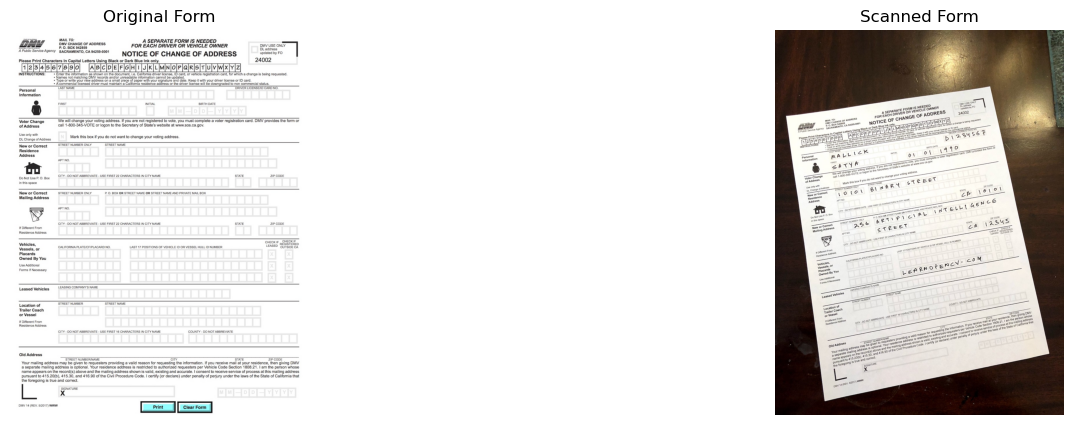

In [6]:
# Display Images

plt.figure(figsize=[18, 5]); 
plt.subplot(121); plt.axis('off'); plt.imshow(im1); plt.title("Original Form")
plt.subplot(122); plt.axis('off'); plt.imshow(im2); plt.title("Scanned Form")

Finding KeyPoints in both the images

In [8]:
# Convert to grayscale
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

# ORB features
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)

keypoints1, descriptors1 = orb.detectAndCompute(im1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(im2_gray, None)

# Draw keypoints
im1_display = cv2.drawKeypoints(im1, keypoints1, outImage=np.array([]),
                                color=(255, 0, 0),
                                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
im2_display = cv2.drawKeypoints(im2, keypoints2, outImage=np.array([]),
                                color=(255, 0, 0),
                                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


Text(0.5, 1.0, 'Scanned Form')

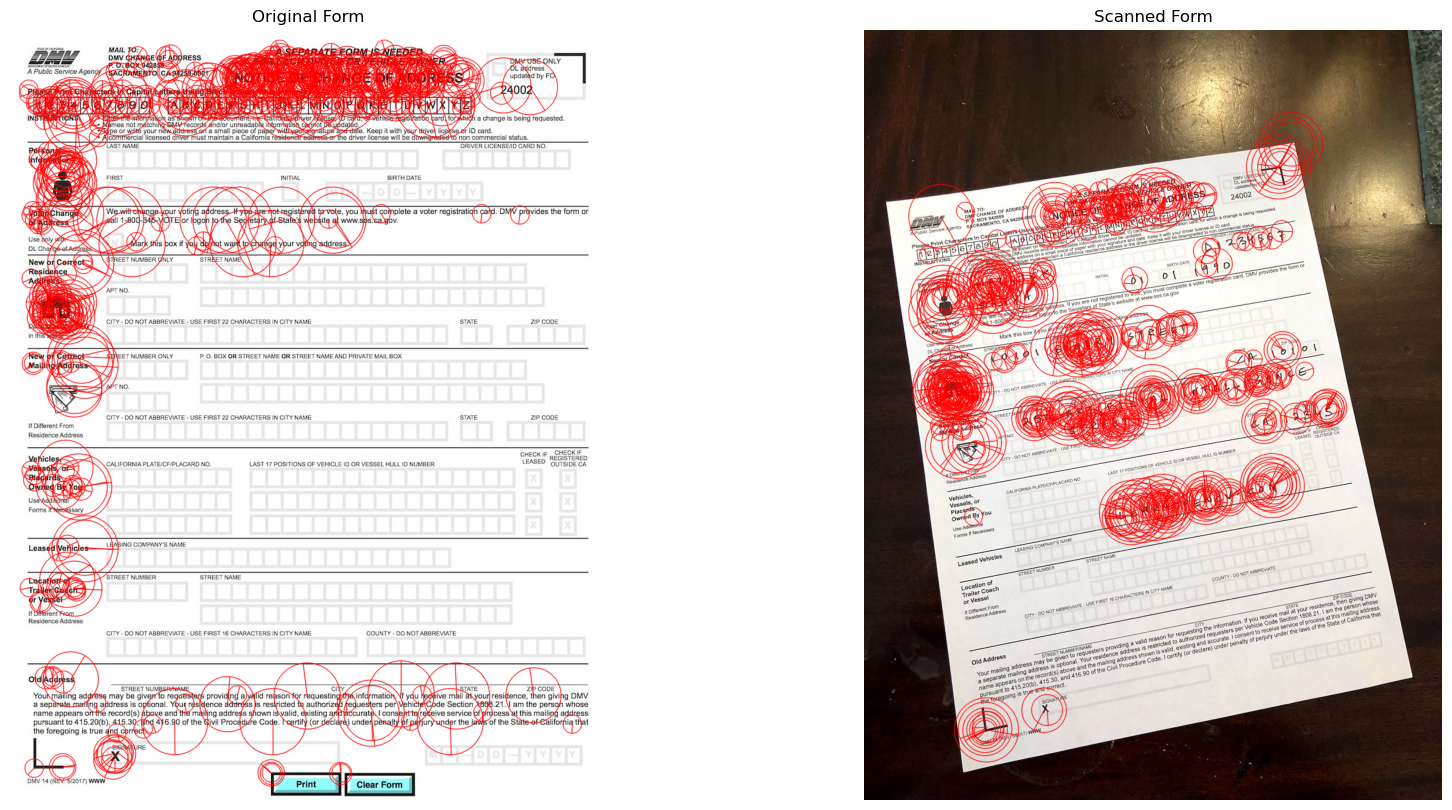

In [11]:
# Show
plt.figure(figsize=[20, 10])
plt.subplot(121); plt.axis('off'); plt.imshow(im1_display); plt.title("Original Form")
plt.subplot(122); plt.axis('off'); plt.imshow(im2_display); plt.title("Scanned Form")


In [12]:
# Match features.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

# Converting to list for sorting as tuples are immutable objects.
matches = list(matcher.match(descriptors1, descriptors2, None))

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches
numGoodMatches = int(len(matches) * 0.1)
matches = matches[:numGoodMatches]

Text(0.5, 1.0, 'Original Form')

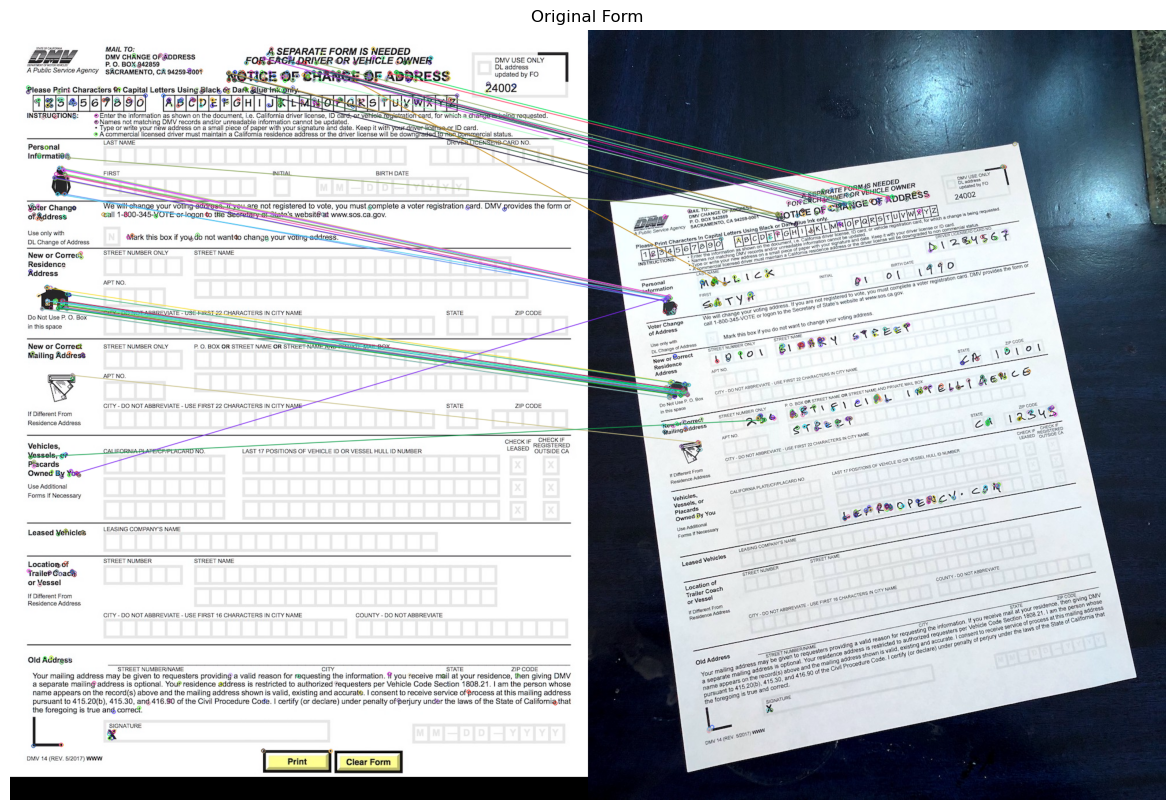

In [16]:
# Draw top matches
im_matches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

plt.figure(figsize=[40, 10])
plt.imshow(im_matches[:, : , ::-1]);plt.axis("off");plt.title("Original Form")

In [19]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)
print(h)

[[ 1.40692593e+00 -2.04020505e-01 -6.60865029e+00]
 [ 2.23293008e-01  1.54696537e+00 -4.89454082e+02]
 [-6.80320989e-05  1.58905649e-04  1.00000000e+00]]


Text(0.5, 1.0, 'Scanned Form')

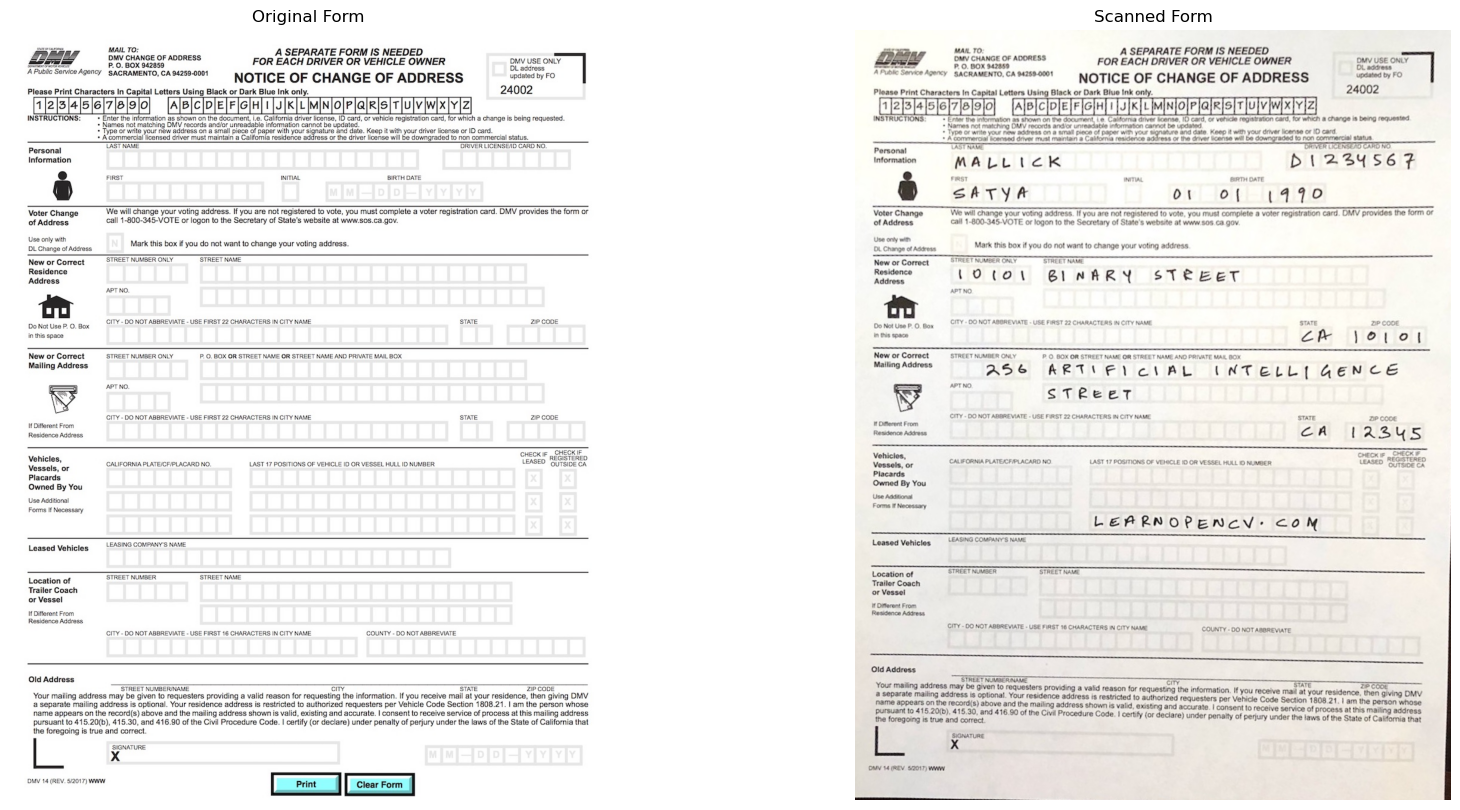

In [18]:
# Use homography to warp image
height, width, channels = im1.shape
im2_reg = cv2.warpPerspective(im2, h, (width, height))

# Display results
plt.figure(figsize=[20, 10])
plt.subplot(121);plt.imshow(im1);    plt.axis("off");plt.title("Original Form")
plt.subplot(122);plt.imshow(im2_reg);plt.axis("off");plt.title("Scanned Form")